In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import splitfolders

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
%cd /Users/irfanmasudi/ANNDL/Challenge/

/Users/irfanmasudi/ANNDL/Challenge


In [4]:
# Dataset folders 
dataset_dir = 'dataset'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
#test_dir = os.path.join(dataset_dir, 'test')

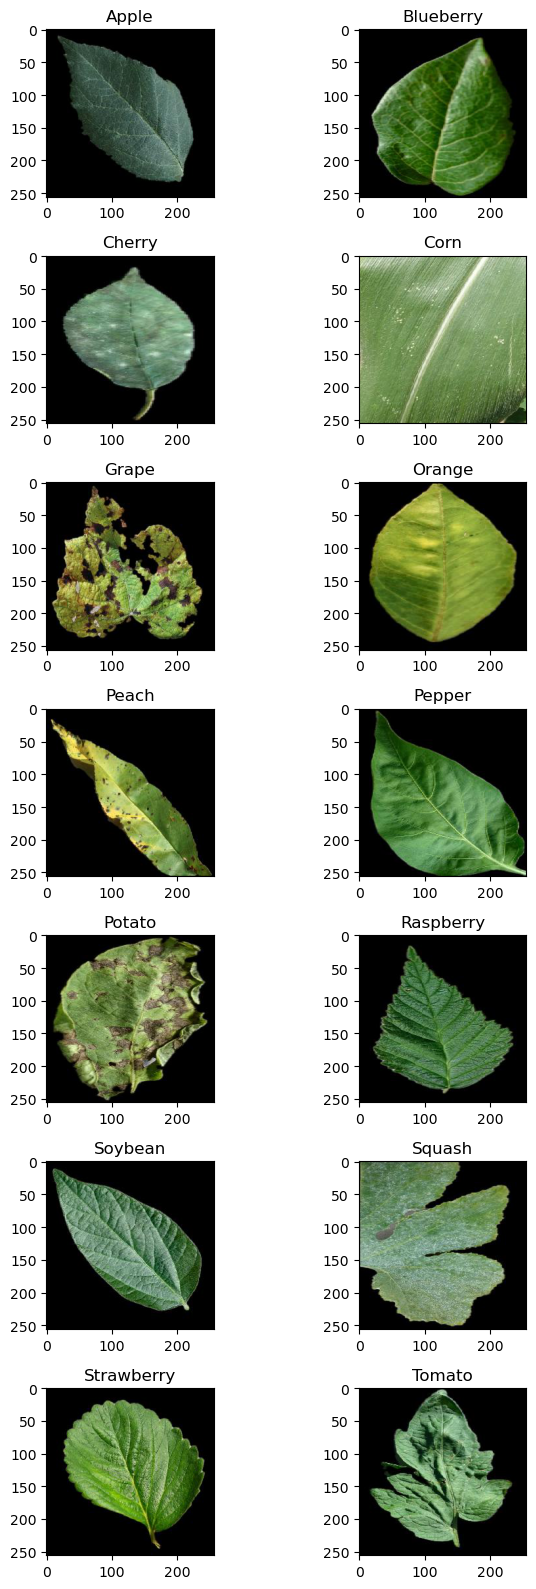

In [5]:
# Plot example images from dataset
labels = ['Apple',       # 0
          'Blueberry',   # 1
          'Cherry',      # 2
          'Corn',        # 3
          'Grape',       # 4
          'Orange',      # 5
          'Peach',       # 6
          'Pepper',      # 7
          'Potato',      # 8
          'Raspberry',   # 9
          'Soybean',     # 10
          'Squash',      # 11
          'Strawberry',  # 12
          'Tomato']      # 13

num_row = 7
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(num_row,8*num_col))
for i in range(num_row*num_col):
    if i < 14:
        class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
        class_img = class_imgs[0]
        img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(np.array(img))
        ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

valid_data_gen = ImageDataGenerator(rotation_range=30,
                                    height_shift_range=50,
                                    width_shift_range=50,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True, 
                                    fill_mode='nearest',
                                    preprocessing_function=tfk.applications.resnet_v2.preprocess_input)
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='nearest',
                                        preprocessing_function=tfk.applications.resnet_v2.preprocess_input) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                   target_size=(224,224),
                                                   color_mode='rgb',
                                                   classes=None, # can be set to labels
                                                   class_mode='categorical',
                                                   batch_size=64,
                                                   shuffle=True,
                                                   seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(224,224),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=64,
                                               shuffle=False,
                                               seed=seed)

Found 15949 images belonging to 14 classes.
Found 1779 images belonging to 14 classes.


In [18]:
def get_next_batch(generator):
    batch = next(generator)

    image = batch[0]
    target = batch[1]

    print("(Input) image shape:", image.shape)
    print("Target shape:",target.shape)

    # Visualize only the first sample
    image = image[0]
    target = target[0]
    target_idx = np.argmax(target)
    print()
    print("Categorical label:", target)
    print("Label:", target_idx)
    print("Class name:", labels[target_idx])
    
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(np.uint8(image))
    plt.show()
    
    return batch

(Input) image shape: (64, 224, 224, 3)
Target shape: (64, 14)

Categorical label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Class name: Apple


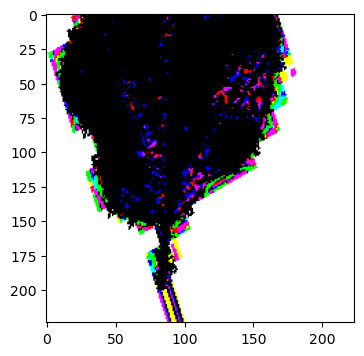

In [20]:
# Get a sample from dataset and show info
_ = get_next_batch(valid_gen)

In [21]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_gen.classes),
                                     y = train_gen.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
class_weights

{0: 1.281455889442391,
 1: 2.7124149659863948,
 2: 2.1740730643402397,
 3: 1.0499670836076367,
 4: 0.8683035714285714,
 5: 0.7242303151394061,
 6: 1.2960344547375264,
 7: 1.6558347176079735,
 8: 1.76896628216504,
 9: 4.806811332127788,
 10: 0.7835036352918059,
 11: 2.2077796234772977,
 12: 1.8829988193624558,
 13: 0.22237249379548812}

In [22]:
resnet = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=False,
    weights='imagenet'
)

234561536/234545216 [==============================] - 68s 0us/step


In [23]:
METRICS = [
      tfk.metrics.TruePositives(name='tp'),
      tfk.metrics.FalsePositives(name='fp'),
      tfk.metrics.TrueNegatives(name='tn'),
      tfk.metrics.FalseNegatives(name='fn'), 
      tfk.metrics.BinaryAccuracy(name='accuracy'),
      tfk.metrics.Precision(name='precision'),
      tfk.metrics.Recall(name='recall'),
      tfk.metrics.AUC(name='auc'),
      tfk.metrics.AUC(name='prc', curve='PR')
]

In [24]:
resnet.trainable = False

inputs = tfk.Input(shape=(224,224,3))

model = resnet(inputs)

# Rebuild top
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(model)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

#x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name="Resnet")
optimizer = tfk.optimizers.Adam()
tl_model.compile(
    optimizer=optimizer, loss=tfk.losses.CategoricalCrossentropy(), metrics=METRICS
)

tl_model.summary()

Model: "Resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet152v2 (Functional)     (None, None, None, 2048)  58331648  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792

In [26]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(tl_model.get_layer('resnet152v2').layers[-20:]):
    if not isinstance(layer, tfkl.BatchNormalization):
        layer.trainable = True
for i, layer in enumerate(tl_model.get_layer('resnet152v2').layers):
    print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

In [28]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('logs/resnet')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)
      
    callbacks = []

  # Model checkpoint
  # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
    callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

  # Early Stopping
  # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_prc',
                                                   patience=5, 
                                                   mode = "max",
                                                   verbose=0,
                                                   restore_best_weights=True)
    
    callbacks.append(es_callback)
    
    lr_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5),
    
    callbacks.append(lr_callback)

    return callbacks

In [29]:
tf.get_logger().setLevel('WARNING') #
tf.get_logger().setLevel('ERROR') # 

# Create folders and callbacks and fit
train_callbacks = create_folders_and_callbacks(model_name='resnetv2')

# Train the model
tl_history = tl_model.fit(
    x = train_gen,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = train_callbacks,
    class_weight = class_weights
).history

/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/200
250/250 [==============================] - 403s 2s/step - loss: 1.6453 - tp: 4155.0000 - fp: 1499.0000 - tn: 205838.0000 - fn: 11794.0000 - accuracy: 0.9405 - precision: 0.7349 - recall: 0.2605 - auc: 0.8708 - prc: 0.4862 - val_loss: 0.7583 - val_tp: 1065.0000 - val_fp: 112.0000 - val_tn: 23015.0000 - val_fn: 714.0000 - val_accuracy: 0.9668 - val_precision: 0.9048 - val_recall: 0.5987 - val_auc: 0.9803 - val_prc: 0.8602


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
250/250 [==============================] - 388s 2s/step - loss: 0.8079 - tp: 10126.0000 - fp: 2066.0000 - tn: 205271.0000 - fn: 5823.0000 - accuracy: 0.9647 - precision: 0.8305 - recall: 0.6349 - auc: 0.9659 - prc: 0.8111 - val_loss: 0.5876 - val_tp: 1346.0000 - val_fp: 179.0000 - val_tn: 22948.0000 - val_fn: 433.0000 - val_accuracy: 0.9754 - val_precision: 0.8826 - val_recall: 0.7566 - val_auc: 0.9825 - val_prc: 0.8991


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/200
250/250 [==============================] - 387s 2s/step - loss: 0.6281 - tp: 11543.0000 - fp: 1839.0000 - tn: 205498.0000 - fn: 4406.0000 - accuracy: 0.9720 - precision: 0.8626 - recall: 0.7237 - auc: 0.9747 - prc: 0.8645 - val_loss: 0.3535 - val_tp: 1524.0000 - val_fp: 117.0000 - val_tn: 23010.0000 - val_fn: 255.0000 - val_accuracy: 0.9851 - val_precision: 0.9287 - val_recall: 0.8567 - val_auc: 0.9936 - val_prc: 0.9565


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/200
250/250 [==============================] - 390s 2s/step - loss: 0.5542 - tp: 12047.0000 - fp: 1643.0000 - tn: 205694.0000 - fn: 3902.0000 - accuracy: 0.9752 - precision: 0.8800 - recall: 0.7553 - auc: 0.9797 - prc: 0.8888 - val_loss: 0.3191 - val_tp: 1548.0000 - val_fp: 75.0000 - val_tn: 23052.0000 - val_fn: 231.0000 - val_accuracy: 0.9877 - val_precision: 0.9538 - val_recall: 0.8702 - val_auc: 0.9944 - val_prc: 0.9643


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/200
250/250 [==============================] - 390s 2s/step - loss: 0.4966 - tp: 12416.0000 - fp: 1510.0000 - tn: 205827.0000 - fn: 3533.0000 - accuracy: 0.9774 - precision: 0.8916 - recall: 0.7785 - auc: 0.9827 - prc: 0.9064 - val_loss: 0.3205 - val_tp: 1534.0000 - val_fp: 102.0000 - val_tn: 23025.0000 - val_fn: 245.0000 - val_accuracy: 0.9861 - val_precision: 0.9377 - val_recall: 0.8623 - val_auc: 0.9952 - val_prc: 0.9648


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/200
250/250 [==============================] - 391s 2s/step - loss: 0.4601 - tp: 12673.0000 - fp: 1468.0000 - tn: 205869.0000 - fn: 3276.0000 - accuracy: 0.9788 - precision: 0.8962 - recall: 0.7946 - auc: 0.9838 - prc: 0.9131 - val_loss: 0.3511 - val_tp: 1529.0000 - val_fp: 97.0000 - val_tn: 23030.0000 - val_fn: 250.0000 - val_accuracy: 0.9861 - val_precision: 0.9403 - val_recall: 0.8595 - val_auc: 0.9935 - val_prc: 0.9582


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/200
250/250 [==============================] - 397s 2s/step - loss: 0.4418 - tp: 12869.0000 - fp: 1378.0000 - tn: 205959.0000 - fn: 3080.0000 - accuracy: 0.9800 - precision: 0.9033 - recall: 0.8069 - auc: 0.9855 - prc: 0.9214 - val_loss: 0.2905 - val_tp: 1543.0000 - val_fp: 97.0000 - val_tn: 23030.0000 - val_fn: 236.0000 - val_accuracy: 0.9866 - val_precision: 0.9409 - val_recall: 0.8673 - val_auc: 0.9958 - val_prc: 0.9711


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/200
250/250 [==============================] - 386s 2s/step - loss: 0.4115 - tp: 13139.0000 - fp: 1265.0000 - tn: 206072.0000 - fn: 2810.0000 - accuracy: 0.9818 - precision: 0.9122 - recall: 0.8238 - auc: 0.9867 - prc: 0.9292 - val_loss: 0.2509 - val_tp: 1589.0000 - val_fp: 89.0000 - val_tn: 23038.0000 - val_fn: 190.0000 - val_accuracy: 0.9888 - val_precision: 0.9470 - val_recall: 0.8932 - val_auc: 0.9956 - val_prc: 0.9741


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/200
250/250 [==============================] - 394s 2s/step - loss: 0.3878 - tp: 13249.0000 - fp: 1320.0000 - tn: 206017.0000 - fn: 2700.0000 - accuracy: 0.9820 - precision: 0.9094 - recall: 0.8307 - auc: 0.9868 - prc: 0.9308 - val_loss: 0.2775 - val_tp: 1584.0000 - val_fp: 84.0000 - val_tn: 23043.0000 - val_fn: 195.0000 - val_accuracy: 0.9888 - val_precision: 0.9496 - val_recall: 0.8904 - val_auc: 0.9950 - val_prc: 0.9705


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/200
250/250 [==============================] - 396s 2s/step - loss: 0.3935 - tp: 13232.0000 - fp: 1352.0000 - tn: 205985.0000 - fn: 2717.0000 - accuracy: 0.9818 - precision: 0.9073 - recall: 0.8296 - auc: 0.9870 - prc: 0.9298 - val_loss: 0.2769 - val_tp: 1575.0000 - val_fp: 94.0000 - val_tn: 23033.0000 - val_fn: 204.0000 - val_accuracy: 0.9880 - val_precision: 0.9437 - val_recall: 0.8853 - val_auc: 0.9953 - val_prc: 0.9707


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/200
250/250 [==============================] - 392s 2s/step - loss: 0.3571 - tp: 13351.0000 - fp: 1296.0000 - tn: 206041.0000 - fn: 2598.0000 - accuracy: 0.9826 - precision: 0.9115 - recall: 0.8371 - auc: 0.9881 - prc: 0.9359 - val_loss: 0.2529 - val_tp: 1608.0000 - val_fp: 91.0000 - val_tn: 23036.0000 - val_fn: 171.0000 - val_accuracy: 0.9895 - val_precision: 0.9464 - val_recall: 0.9039 - val_auc: 0.9950 - val_prc: 0.9744


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/200
250/250 [==============================] - 393s 2s/step - loss: 0.3605 - tp: 13400.0000 - fp: 1289.0000 - tn: 206048.0000 - fn: 2549.0000 - accuracy: 0.9828 - precision: 0.9122 - recall: 0.8402 - auc: 0.9890 - prc: 0.9383 - val_loss: 0.2838 - val_tp: 1588.0000 - val_fp: 108.0000 - val_tn: 23019.0000 - val_fn: 191.0000 - val_accuracy: 0.9880 - val_precision: 0.9363 - val_recall: 0.8926 - val_auc: 0.9943 - val_prc: 0.9687


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 13/200
250/250 [==============================] - 397s 2s/step - loss: 0.3605 - tp: 13469.0000 - fp: 1212.0000 - tn: 206125.0000 - fn: 2480.0000 - accuracy: 0.9835 - precision: 0.9174 - recall: 0.8445 - auc: 0.9888 - prc: 0.9396 - val_loss: 0.2289 - val_tp: 1614.0000 - val_fp: 77.0000 - val_tn: 23050.0000 - val_fn: 165.0000 - val_accuracy: 0.9903 - val_precision: 0.9545 - val_recall: 0.9073 - val_auc: 0.9966 - val_prc: 0.9801


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 14/200
250/250 [==============================] - 394s 2s/step - loss: 0.3247 - tp: 13685.0000 - fp: 1198.0000 - tn: 206139.0000 - fn: 2264.0000 - accuracy: 0.9845 - precision: 0.9195 - recall: 0.8580 - auc: 0.9900 - prc: 0.9459 - val_loss: 0.1720 - val_tp: 1664.0000 - val_fp: 64.0000 - val_tn: 23063.0000 - val_fn: 115.0000 - val_accuracy: 0.9928 - val_precision: 0.9630 - val_recall: 0.9354 - val_auc: 0.9977 - val_prc: 0.9872


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 15/200
250/250 [==============================] - 392s 2s/step - loss: 0.3453 - tp: 13694.0000 - fp: 1141.0000 - tn: 206196.0000 - fn: 2255.0000 - accuracy: 0.9848 - precision: 0.9231 - recall: 0.8586 - auc: 0.9893 - prc: 0.9457 - val_loss: 0.1615 - val_tp: 1661.0000 - val_fp: 64.0000 - val_tn: 23063.0000 - val_fn: 118.0000 - val_accuracy: 0.9927 - val_precision: 0.9629 - val_recall: 0.9337 - val_auc: 0.9987 - val_prc: 0.9889


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/200
250/250 [==============================] - 395s 2s/step - loss: 0.3312 - tp: 13667.0000 - fp: 1146.0000 - tn: 206191.0000 - fn: 2282.0000 - accuracy: 0.9846 - precision: 0.9226 - recall: 0.8569 - auc: 0.9899 - prc: 0.9476 - val_loss: 0.1733 - val_tp: 1665.0000 - val_fp: 63.0000 - val_tn: 23064.0000 - val_fn: 114.0000 - val_accuracy: 0.9929 - val_precision: 0.9635 - val_recall: 0.9359 - val_auc: 0.9973 - val_prc: 0.9858


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 17/200
250/250 [==============================] - 395s 2s/step - loss: 0.3003 - tp: 13817.0000 - fp: 1127.0000 - tn: 206210.0000 - fn: 2132.0000 - accuracy: 0.9854 - precision: 0.9246 - recall: 0.8663 - auc: 0.9908 - prc: 0.9510 - val_loss: 0.2674 - val_tp: 1578.0000 - val_fp: 97.0000 - val_tn: 23030.0000 - val_fn: 201.0000 - val_accuracy: 0.9880 - val_precision: 0.9421 - val_recall: 0.8870 - val_auc: 0.9956 - val_prc: 0.9730


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 18/200
250/250 [==============================] - 398s 2s/step - loss: 0.3234 - tp: 13711.0000 - fp: 1114.0000 - tn: 206223.0000 - fn: 2238.0000 - accuracy: 0.9850 - precision: 0.9249 - recall: 0.8597 - auc: 0.9899 - prc: 0.9479 - val_loss: 0.2567 - val_tp: 1608.0000 - val_fp: 91.0000 - val_tn: 23036.0000 - val_fn: 171.0000 - val_accuracy: 0.9895 - val_precision: 0.9464 - val_recall: 0.9039 - val_auc: 0.9956 - val_prc: 0.9739


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 19/200
250/250 [==============================] - 398s 2s/step - loss: 0.3123 - tp: 13812.0000 - fp: 1106.0000 - tn: 206231.0000 - fn: 2137.0000 - accuracy: 0.9855 - precision: 0.9259 - recall: 0.8660 - auc: 0.9907 - prc: 0.9515 - val_loss: 0.1524 - val_tp: 1680.0000 - val_fp: 57.0000 - val_tn: 23070.0000 - val_fn: 99.0000 - val_accuracy: 0.9937 - val_precision: 0.9672 - val_recall: 0.9444 - val_auc: 0.9982 - val_prc: 0.9891


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/200
250/250 [==============================] - 394s 2s/step - loss: 0.3195 - tp: 13796.0000 - fp: 1140.0000 - tn: 206197.0000 - fn: 2153.0000 - accuracy: 0.9853 - precision: 0.9237 - recall: 0.8650 - auc: 0.9898 - prc: 0.9483 - val_loss: 0.2131 - val_tp: 1635.0000 - val_fp: 70.0000 - val_tn: 23057.0000 - val_fn: 144.0000 - val_accuracy: 0.9914 - val_precision: 0.9589 - val_recall: 0.9191 - val_auc: 0.9969 - val_prc: 0.9822


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 21/200
250/250 [==============================] - 390s 2s/step - loss: 0.3029 - tp: 13937.0000 - fp: 1101.0000 - tn: 206236.0000 - fn: 2012.0000 - accuracy: 0.9861 - precision: 0.9268 - recall: 0.8738 - auc: 0.9906 - prc: 0.9514 - val_loss: 0.1648 - val_tp: 1675.0000 - val_fp: 50.0000 - val_tn: 23077.0000 - val_fn: 104.0000 - val_accuracy: 0.9938 - val_precision: 0.9710 - val_recall: 0.9415 - val_auc: 0.9974 - val_prc: 0.9863


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 22/200
250/250 [==============================] - 386s 2s/step - loss: 0.3064 - tp: 13900.0000 - fp: 1097.0000 - tn: 206240.0000 - fn: 2049.0000 - accuracy: 0.9859 - precision: 0.9269 - recall: 0.8715 - auc: 0.9906 - prc: 0.9524 - val_loss: 0.1620 - val_tp: 1666.0000 - val_fp: 69.0000 - val_tn: 23058.0000 - val_fn: 113.0000 - val_accuracy: 0.9927 - val_precision: 0.9602 - val_recall: 0.9365 - val_auc: 0.9978 - val_prc: 0.9873


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 23/200
250/250 [==============================] - 441s 2s/step - loss: 0.2902 - tp: 14049.0000 - fp: 1043.0000 - tn: 206294.0000 - fn: 1900.0000 - accuracy: 0.9868 - precision: 0.9309 - recall: 0.8809 - auc: 0.9912 - prc: 0.9561 - val_loss: 0.1560 - val_tp: 1685.0000 - val_fp: 48.0000 - val_tn: 23079.0000 - val_fn: 94.0000 - val_accuracy: 0.9943 - val_precision: 0.9723 - val_recall: 0.9472 - val_auc: 0.9974 - val_prc: 0.9872


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 24/200
250/250 [==============================] - 387s 2s/step - loss: 0.3051 - tp: 13925.0000 - fp: 1113.0000 - tn: 206224.0000 - fn: 2024.0000 - accuracy: 0.9860 - precision: 0.9260 - recall: 0.8731 - auc: 0.9899 - prc: 0.9506 - val_loss: 0.1985 - val_tp: 1657.0000 - val_fp: 77.0000 - val_tn: 23050.0000 - val_fn: 122.0000 - val_accuracy: 0.9920 - val_precision: 0.9556 - val_recall: 0.9314 - val_auc: 0.9955 - val_prc: 0.9811


/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [30]:
# Save best epoch model
tl_model.save("best_model/resnet/resnetv2")

/Users/irfanmasudi/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [61]:
del tl_model

In [62]:
tl_model = tfk.models.load_model("best_model/resnet/resnetv2")

In [32]:
predictions = tl_model.predict(valid_gen)
y_pred = np.argmax(predictions, axis=1)
#print('Confusion Matrix')
#print(confusion_matrix(valid_gen.classes, y_pred))

In [33]:
#Defining function for confusion matrix plot
y_true = valid_gen.classes
classes = labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):


    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Accuracy: 0.9578
Precision: 0.9471
Recall: 0.9611
F1: 0.9537
Normalized confusion matrix


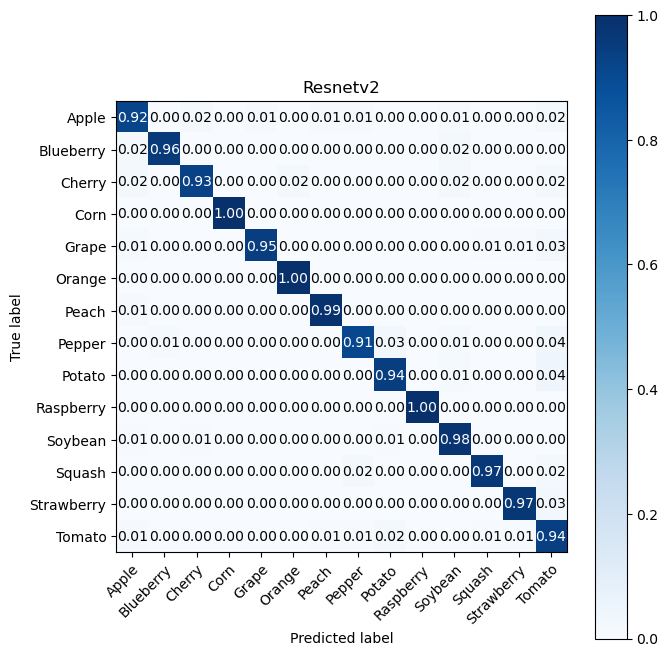

In [35]:
#Compute the classification metrics
accuracy = accuracy_score(valid_gen.classes, np.argmax(predictions, axis=-1))
precision = precision_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(valid_gen.classes, np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


plot_confusion_matrix(y_true, y_pred, classes=labels, normalize = True,
                      title='Resnetv2')
#plt.savefig('InceptionResnet.png')
plt.show()

In [ ]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, X_train, y_train)

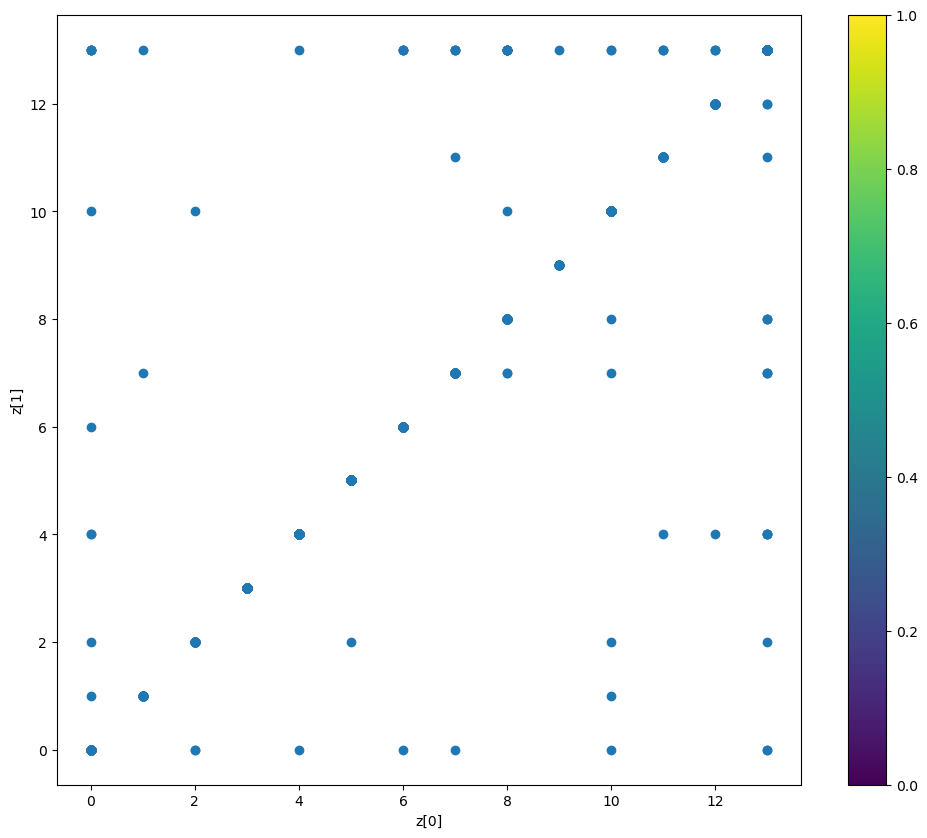

In [38]:
plt.figure(figsize=(12, 10))
plt.scatter(y_pred, y_true)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()